In [1]:
import flirimageextractor
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
import subprocess
import cv2

In [2]:
def save_thermal_csv(flirobj, filename):
    """
    Function that saves the numpy array as a .csv
    
    INPUTS:
    1) flirobj: the flirimageextractor object.
    2) filename: a string containing the location of the output csv file. 
    
    OUTPUTS:
    Saves a csv of the thermal image where each value is a pixel in the thermal image. 
    """
    data = flirobj.get_thermal_np()
    np.savetxt(filename, data, delimiter=',')

def extract_coarse_image(flirobj):
    """
    Function that creates the coarse RGB image that matches the resolution of the thermal image.
    
    INPUTS:
    1) flirobj: the flirimageextractor object.
    
    OUTPUTS:
    1) crop: a 3D numpy arary of RGB image that matches resolution and field of view of thermal image.
    """
    # Get RGB Image
    visual = flirobj.rgb_image_np
    highres_ht = visual.shape[0]
    highres_wd = visual.shape[1]
    
    # Getting Values for Offset
    offsetx = int(subprocess.check_output([flirobj.exiftool_path, "-OffsetX", "-b", flirobj.flir_img_filename])) 
    offsety = int(subprocess.check_output([flirobj.exiftool_path, "-OffsetY", "-b", flirobj.flir_img_filename])) 
    pipx1 = int(subprocess.check_output([flirobj.exiftool_path, "-PiPX1", "-b", flirobj.flir_img_filename])) 
    pipx2 = int(subprocess.check_output([flirobj.exiftool_path, "-PiPX2", "-b", flirobj.flir_img_filename])) # Width
    pipy1 = int(subprocess.check_output([flirobj.exiftool_path, "-PiPY1", "-b", flirobj.flir_img_filename])) 
    pipy2 = int(subprocess.check_output([flirobj.exiftool_path, "-PiPY2", "-b", flirobj.flir_img_filename])) # Height
    real2ir = float(subprocess.check_output([flirobj.exiftool_path, "-Real2IR", "-b", flirobj.flir_img_filename]))
    
    # Set up Arrays
    height_range = np.arange(0,highres_ht,real2ir).astype(int)
    width_range = np.arange(0,highres_wd,real2ir).astype(int)
    htv, wdv = np.meshgrid(height_range,width_range)
    
    # Assigning low resolution data
    lowres = np.swapaxes(visual[htv, wdv,  :], 0, 1)
    
    # Getting additional variables
    center_height = lowres.shape[0]/2
    center_width = lowres.shape[1]/2
    h1 = center_height - ((pipy2 - pipy1)/2) + offsety 
    h2 = center_height + ((pipy2 - pipy1)/2) + offsety 
    w1 = center_width - ((pipx2 - pipx1)/2) + offsetx
    w2 = center_width + ((pipx2 - pipx1)/2) + offsetx
    #height_range = np.arange(h1,h2).astype(int)
    #width_range = np.arange(w1,w2).astype(int)
    height_range = np.arange(-offsety,-offsety+pipy2).astype(int)
    width_range = np.arange(-offsetx,-offsetx+pipx2).astype(int)
    
    # Cropping low resolution data
    xv, yv = np.meshgrid(height_range,width_range)
    crop = np.swapaxes(lowres[xv, yv, :],0,1)
    
    return lowres, crop

def classify_rgb(flirobj):
    """
    """
    img = flirobj.rgb_image_np
    vectorized = img.reshape((-1,3))
    vectorized = np.float32(vectorized)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 6
    attempts = 10
    ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))

    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(result_image)
    plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
    plt.show()

    return result_image


In [3]:
# Loading FLIR Object
flir = flirimageextractor.FlirImageExtractor(palettes=[cm.jet, cm.bwr, cm.gist_ncar],exiftool_path="C:\\Users\\susanmeerdink\\.utilities\\exiftool.exe")
flir.process_image('C:\\Users\\susanmeerdink\\Dropbox (UFL)\\Analysis\\Thermal Experiment\\Soledad\\IR_55920_Copy.jpg', RGB=True)

In [4]:
# Save the thermal data as CSV
filename = 'C:\\Users\\susanmeerdink\\Dropbox (UFL)\\Analysis\\Thermal Experiment\\Soledad\\IR_55920_Copy.csv'
save_thermal_csv(flir, filename)

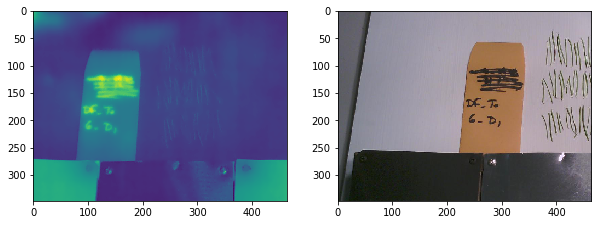

In [5]:
# Exracting coarse RGB image
[lowres_img, crop_img] = extract_coarse_image(flir)

# Get thermal data
therm = flir.get_thermal_np()

# Compare extraction
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(therm)
plt.subplot(1,2,2)
plt.imshow(crop_img)
plt.show()

In [6]:
# Not working right now
# [im1Reg, h] = alignImages(lowres_img, therm)
# plt.figure()
# plt.imshow(im1Reg)
# plt.show()

In [7]:
# results = classify_rgb(flir)

In [8]:
# Not working right now
# def alignImages(rgb, temp):
    
#     MAX_FEATURES = 50
#     GOOD_MATCH_PERCENT = 0.50
 
#     # Convert images to grayscale
#     im1Gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
#     im2Gray = cv2.normalize(src=temp, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
#     im2Gray = 255 - im2Gray

#     # Plotting Gray Scale Images
#     plt.figure(figsize=(10,10))
#     plt.subplot(1,2,1)
#     plt.imshow(im1Gray)
#     plt.title('RGB Image to Gray Scale')
#     plt.subplot(1,2,2)
#     plt.imshow(im2Gray)
#     plt.title('Thermal Image to Gray Scale')
#     plt.show()
   
#     # Detect ORB features and compute descriptors.
#     orb = cv2.ORB_create(MAX_FEATURES) # 
#     [keypoints1, descriptors1] = orb.detectAndCompute(im1Gray, None)
#     [keypoints2, descriptors2] = orb.detectAndCompute(im2Gray, None)

#     # Match features.
#     #matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
#     matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True) 
#     matches = matcher.match(descriptors1, descriptors2, None)

#     # Sort matches by score
#     matches.sort(key=lambda x: x.distance, reverse=False)

#     # Remove not so good matches
#     numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
#     matches = matches[:numGoodMatches]

#     # Draw top matches
#     imMatches = cv2.drawMatches(im1Gray, keypoints1, im2Gray, keypoints2, matches, None)
    
#     plt.figure(figsize=(20,20))
#     plt.imshow(imMatches)
#     plt.show()
    
#     cv2.imwrite("matches.jpg", imMatches)

#     # Extract location of good matches
#     points1 = np.zeros((len(matches), 2), dtype=np.float32)
#     points2 = np.zeros((len(matches), 2), dtype=np.float32)

#     for i, match in enumerate(matches):
#         points1[i, :] = keypoints1[match.queryIdx].pt
#         points2[i, :] = keypoints2[match.trainIdx].pt

#     # Find homography
#     [homography, mask] = cv2.findHomography(points1, points2, cv2.RANSAC)
    
#     plt.figure(figsize=(10,10))
#     plt.imshow(homography)
#     plt.show()

#     # Use homography
#     [height, width, channels] = rgb.shape
#     #im1Reg = cv2.warpPerspective(rgb, h, (width, height))
#     transformed_img = cv2.warpPerspective(rgb, homography, (width, height))

#     return transformed_img, homography